<div style="margin:auto; float:right; margin-left: 50px; width: 45%">
<img src="images/features_extraction_only.jpeg">
<em>Esamp [ref??]</em>
</div>


<p style="color: #a00; font-weight: 700">>> TASK 1</p>

The concept of building a set of descriptors for an image is depicted on the image on top of this section. For example, if one wants to find a concise set of features that describe a `bike`, he could use the concepts of [`wheel`, `chain`, `saddle`]. If now we describe another image using those three concepts, it is very likely that it will also contain a bike (or something with a wheen, a saddle and a chain), therefore the two images will probably be similar.

In order to abstract this reasoning into an algorithm that we can implement into a computer, we have to be more precise into what are those _features_. In general, we would like to find some _"salient" local_ regions of the image where something interesting is depicted, in order to find a set of descriptor of the image that summarize its content.

To do so we have to define a rule to find those _salient_ regions and a procedure to build a _description_ of them.

> __In this section we are going to learn how to implement the function:__
```python
def localize_blobs(self, image):
    raise features
```
__which extract a set of points from the image where we think that something interesting is happening.__

Such localized regions must possess a set of properties for them to be _good_ descriptors of the image, in particoular:

1. The features must be extracted using a roboust and repeatable procedure. In particoular they have to be roboust to variations of scale, rotations, translations, variations of colors etc.
2. They must be computed in an efficient manner.

To perform fast manipulations on the images, we will use the [open-cv library](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html). We start by importing it, together with the `numpy` library and the `matplotlib` library for image plotting:

In [2]:
import numpy as np
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import cv2

We now make a class that takes care of handling our image dataset

In [140]:
# Loading the name of all files
from os import listdir
from os.path import isfile, join
import random

class Dataset():
    def __init__(self, folder="jpg"):
        self.path = 'data/' + folder
        self.all_images = [f for f in listdir(self.path) if isfile(join(self.path, f))]
    
    def print_files(self):
        print(self.all_images[:5])
        
    def get_image_by_name(self, image_name=None, gray=True):
        image = cv2.imread(self.path + '/' + image_name)
        if gray:
            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            return np.float32(gray)
        else:
            return image
    
    def get_random_image(self):
        return self.get_image_by_name(random.choice(self.all_images))
    
def show_image(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img,aspect="equal", cmap="gray")
    
    
dataset = Dataset()

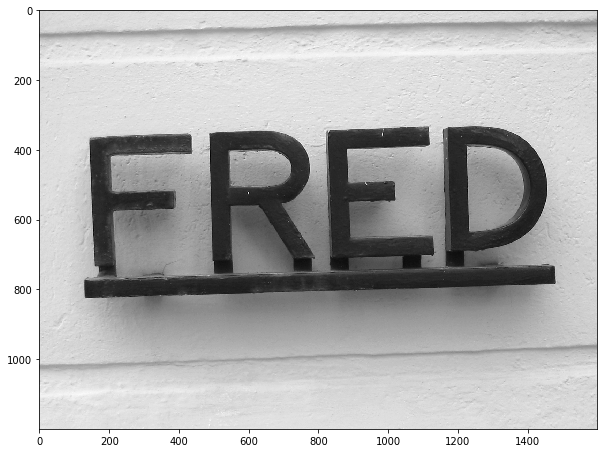

In [141]:
# Loading and displaying an image
img = dataset.get_image_by_name('110901.jpg')
show_image(img)

### Corner detector 

A possible set of interesting points is given by the corners of the objects in the image. To find them, we are going to use the Corner detector operator developed by [Harris and Stephens](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html).

##### Derivation of the algorithm

[Can add some math here if not too much]

##### Implementation

The idea boils down to the following steps:

1. We find the two gradient components $I_x$ and $I_y$ of the images using [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator)
2. From them, we build the score function
$$
R = g(I^2_x)g(I^2_y) - g(I_xI_y)^2 - \alpha\left[g(I_x)+g(I_y)\right]^2
$$
where $g(\cdot)$ is a blurring operator obtained by filtering with a gaussian kernel of size $\sigma$.
3. Find the local maxima of this function above a given treshold $k$

Both the Sobel and blurring operators are computed in a similar fashion. For the Sobel operators, we convolve the image with the following kernels:
$$
I_x = \begin{bmatrix}
+1 & 0 & -1\\ 
+2 & 0 & -1\\ 
+1 & 0 & -1
\end{bmatrix} * I \qquad \text{ and } \qquad
I_y = \begin{bmatrix}
+1 & +2 & +1\\ 
0& 0 & 0\\ 
-1 & +2 & -1
\end{bmatrix} * I,
$$
while for the blurring operator we use a gaussian kernel.

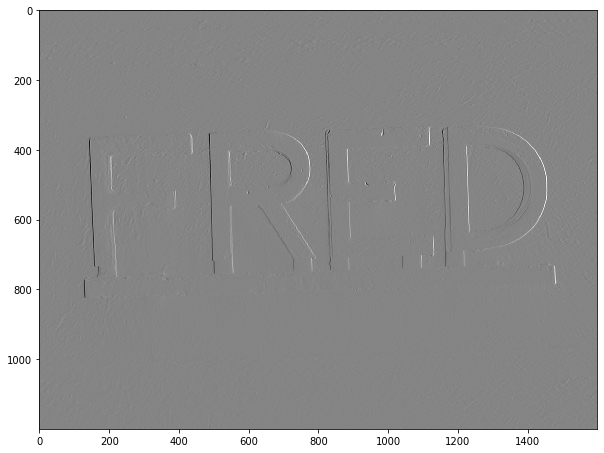

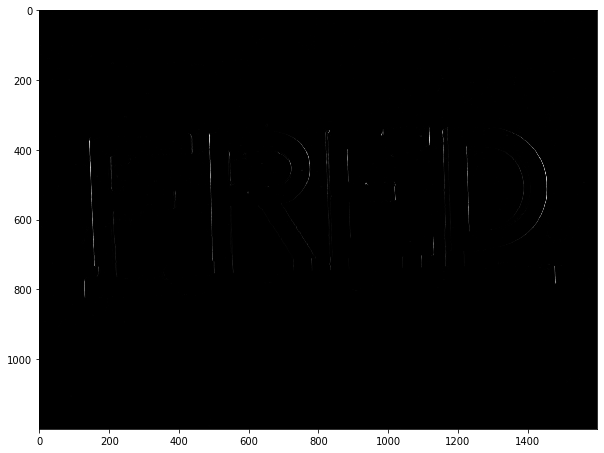

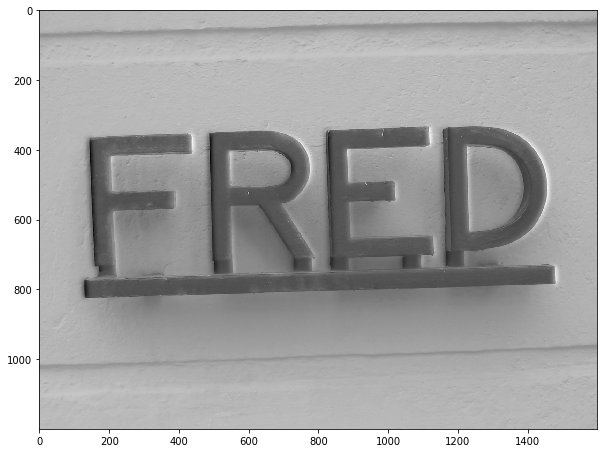

In [142]:
#Example of using different filters
Ix = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
show_image(Ix)
plt.show()

show_image(Ix**2)
plt.show()

g_Ix = cv2.GaussianBlur(Ix,(45,45),0)
show_image(0.1*g_Ix + img)
plt.show()


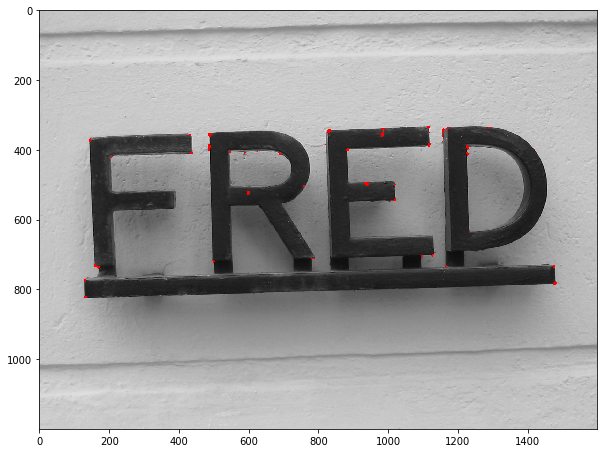

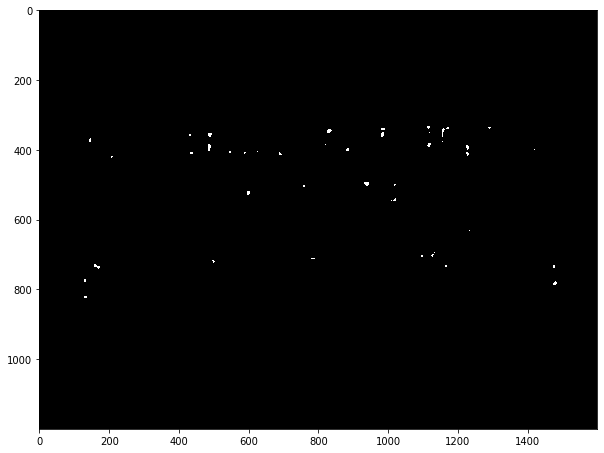

In [70]:
def get_corners(img):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

    sobelx2 = cv2.GaussianBlur(sobelx**2,(15,15),0)
    
    ####### TO DO BY STUDENT ########
    sobely2 = cv2.GaussianBlur(sobely**2,(15,15),0)

    sq = sobelx2*sobely2
                              
    mix = cv2.GaussianBlur(sobelx*sobely,(15,15),0)**2
    sumgrad = cv2.add(
        cv2.GaussianBlur(sobelx,(15,15),0),
        cv2.GaussianBlur(sobely,(15,15),0)
    )
    sumgrad2 = cv2.multiply(sumgrad,sumgrad)
    R = sq - mix - 0.1*sumgrad2
    binary_map_of_corners = R > 0.05*R.max()
    ##################################
                              
    return binary_map_of_corners

def show_corners_on_image(img, corners):
    img_3channels = cv2.cvtColor(img/255,cv2.COLOR_GRAY2RGB)
    img_3channels[corners]=[1,0,0]
    show_image(img_3channels)
    plt.show()

show_corners_on_image(img,get_corners(img))
show_image(get_corners(img))


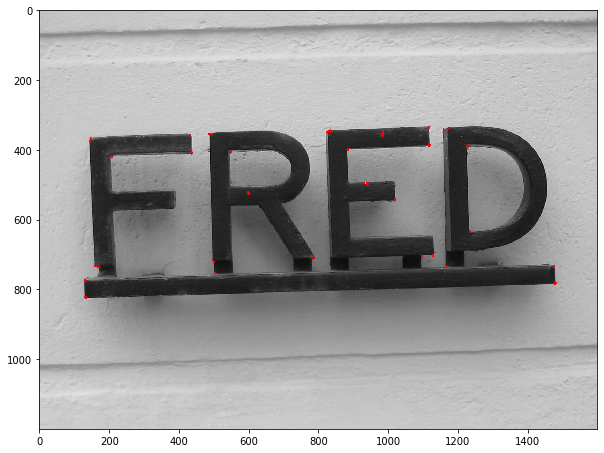

In [71]:
# Compare to OpenCV implementation   
dst = cv2.cornerHarris(img,4,21,0.01)
dst = cv2.dilate(dst,None)
dst = dst>0.05*dst.max()

show_corners_on_image(img,dst)

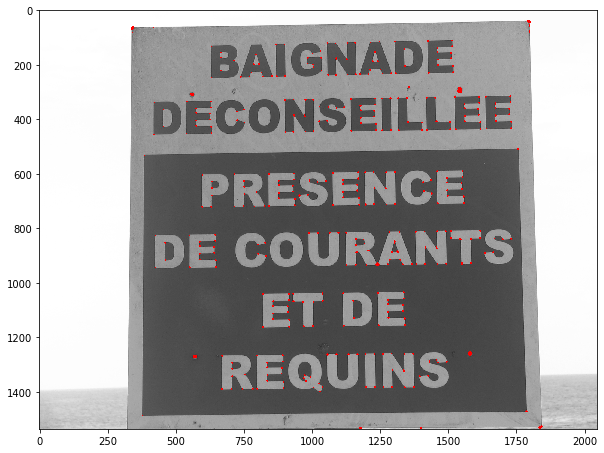

In [122]:
# Try on new image, show that not very good
img = dataset.get_image_by_name('106001.jpg')
show_corners_on_image(img,get_corners(img))

In [139]:
# We need better descriptors (Look at the O, for example), we use MSER

In [153]:
## Read image and change the color space
def detect_MSER_blobs(img, min_area=4000, max_area=200000):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## Get mser, and set parameters
    mser = cv2.MSER_create(_max_variation = 0.5)
    mser.setMinArea(min_area)
    mser.setMaxArea(max_area)
    
    ## Do mser detection, get the coodinates and bboxes
    coordinates, bboxes = mser.detectRegions(gray)

    ## Filter the coordinates
    vis = img.copy()
    coords = []
    for coord in coordinates:
        bbox = cv2.boundingRect(coord)
        x,y,w,h = bbox
        if w< 20 or h < 20 or w/h > 5 or h/w > 5:
            continue
        coords.append(coord)
    return coords

def show_MSER_blobs(img, blobs):

    ## colors 

    ## Fill with random colors
    np.random.seed(0)
    canvas1 = img.copy()
    canvas3 = np.zeros_like(img)

    for cnt in blobs:
        # Show in separate image
        xx = cnt[:,0]
        yy = cnt[:,1]
        color = [random.randint(0, 255) for _ in range(3)]
        canvas3[yy, xx] = color

        # Show as BBox
        # get the min area rect
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        # convert all coordinates floating point values to int
        box = np.int0(box)
        # draw a red 'nghien' rectangle
        canvas1 = cv2.drawContours(canvas1, [box], 0, (0, 255, 0), 3)

    ## Show
    RGB_image = cv2.cvtColor(canvas1, cv2.COLOR_BGR2RGB)
    show_image(RGB_image)
    plt.show()
    
    show_image(canvas3)
    plt.show()

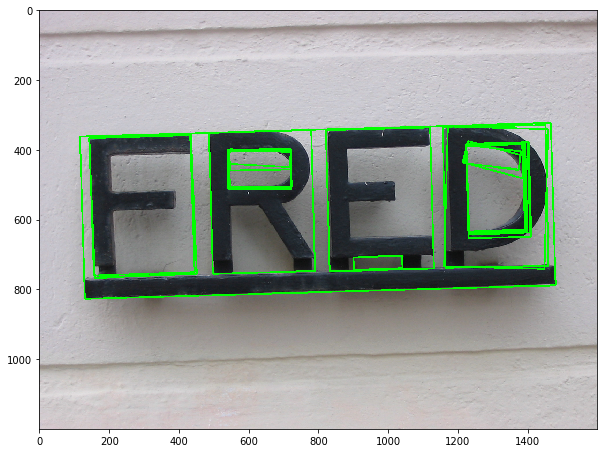

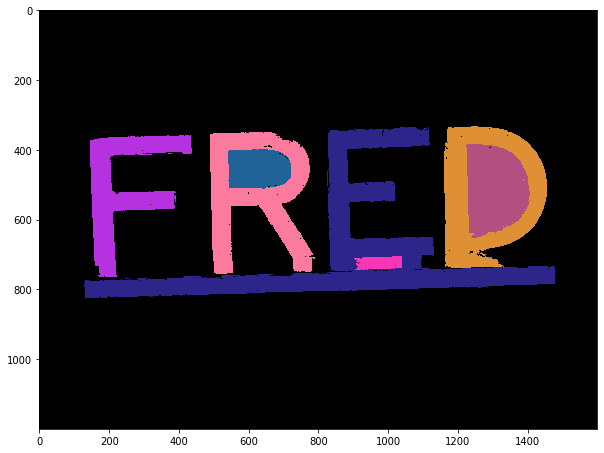

In [155]:
img = dataset.get_image_by_name('110901.jpg', gray=False)
blobs = detect_MSER_blobs(img)
show_MSER_blobs(img, blobs)

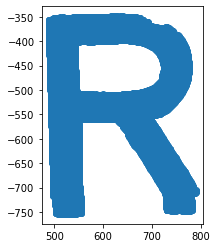

In [137]:
# Example of what each blob contains. Essentially, is a list of pixel coordinate-pairs that identify a 
# connected region of the image
sample_blob = np.array(blobs[3])
fig, ax = plt.subplots()
ax.scatter(sample_blob[:,0], -sample_blob[:,1])
ax.set_aspect('equal')

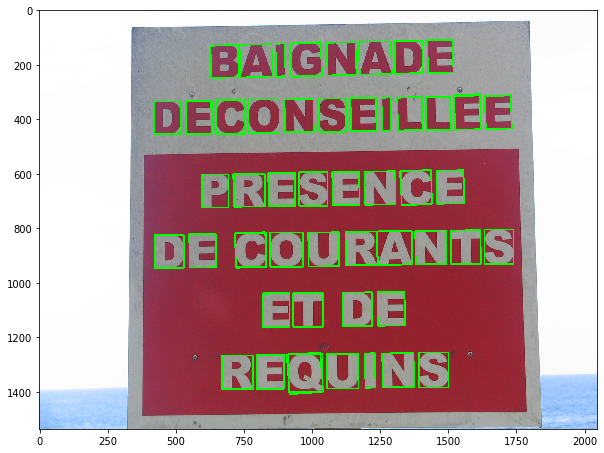

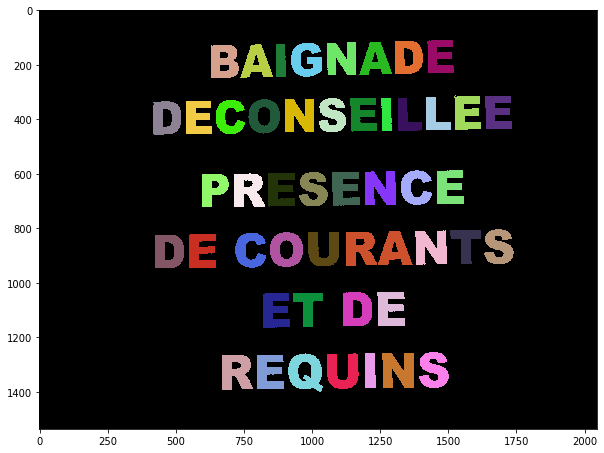

In [138]:
# Try on the previous image
img = dataset.get_image_by_name('106001.jpg', gray=False)
blobs = detect_MSER_blobs(img)
show_MSER_blobs(img, blobs)